In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
import os

p1 = 0.4
p2 = 0.7
p3 = 1
K = 80           # number of hidden units
gamma = 0.01      # learning rate
num_epochs = 100000
lambda_reg = 0.003  # regularization weight
eps = 1e-8  # threshold for counting nonzeros
incl_bias_sparsity = False # whether or not to include and penalize biases in the sparsity measure
save_figs = True # optional: save plots as .png

torch.manual_seed(20)

# dataset
x_train = torch.tensor([[-2.0], [-1.0], [0.0], [1.0], [2.0], [3.0]])
y_train = torch.tensor([[0.0],  [0.0],  [1.0], [1.0], [0.0],  [0.0]])

# for saving figures
if save_figs:
    fig_dir = 'figs/univariate/'
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

In [2]:
# Define single-hidden-layer ReLU network
class ReLURegNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        # hidden layer weights w_k and biases b_k
        self.hidden = nn.Linear(input_dim, hidden_dim, bias=True)
        # output weights v_k (no bias)
        self.output = nn.Linear(hidden_dim, 1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        z = self.hidden(x)        # pre-activations [N, K]
        h = self.relu(z)          # activations [N, K]
        out = self.output(h)      # output [N, 1]
        return out, z

In [3]:
# Instantiate models
model_none = ReLURegNet(1, K)
model_wd = copy.deepcopy(model_none)
model_p1 = copy.deepcopy(model_none)
model_p2 = copy.deepcopy(model_none)
model_p3 = copy.deepcopy(model_none)

# Optimizers
opt_none = optim.Adam(model_none.parameters(), lr=gamma)
opt_wd = optim.AdamW(model_wd.parameters(), lr=gamma, weight_decay=lambda_reg)
opt_p1 = optim.Adam(model_p1.parameters(), lr=gamma)
opt_p2 = optim.Adam(model_p2.parameters(), lr=gamma)
opt_p3 = optim.Adam(model_p3.parameters(), lr=gamma)

criterion = nn.MSELoss()

# History storage
epochs = []
metrics = {
    'none': {'mse': [], 'spars': [], 'act': []},
    'wd': {'mse': [], 'spars': [], 'act': []},
    'p1': {'mse': [], 'spars': [], 'act': [], 'lp': []},
    'p2': {'mse': [], 'spars': [], 'act': [], 'lp': []},
    'p3': {'mse': [], 'spars': [], 'act': [], 'lp': []},
}

# Utility: lp path norm
def lp_path_norm(model, p):
    if incl_bias_sparsity:
        W = torch.cat((model.hidden.weight, model.hidden.bias[:, None]), dim=1)
    else:
        W = model.hidden.weight
    V = model.output.weight.view(-1, 1)
                  
    return (W*V).abs().pow(p).sum().item()

# Utility: count nonzeros (l0 path norm)
def count_nonzero(model):
    if incl_bias_sparsity:
        W = torch.cat((model.hidden.weight, model.hidden.bias[:, None]), dim=1)
    else:
        W = model.hidden.weight
    V = model.output.weight.view(-1, 1)
                  
    return int((W * V).abs().gt(eps).sum().item())

# Utility: count active neurons
def count_active_neurons(model):
    if incl_bias_sparsity:
        W = torch.cat((model.hidden.weight, model.hidden.bias[:, None]), dim=1)
    else:
        W = model.hidden.weight
    V = model.output.weight.view(-1, 1)
                  
    return int(((W*V).abs().ge(eps).any(dim=1)).sum().item())

Epoch 1:  no regularization (MSE=3.37e-01,spars=80,act=80) | WD (MSE=3.37e-01,spars=80,act=80) | p=0.4 (MSE=3.37e-01,spars=80,act=80) | p=0.7 (MSE=3.37e-01,spars=80,act=80) | p=1 (MSE=3.37e-01,spars=80,act=80) | 


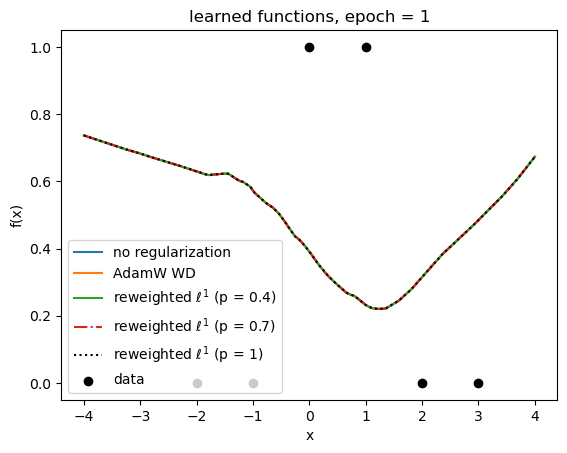

Epoch 5000:  no regularization (MSE=2.61e-07,spars=80,act=80) | WD (MSE=8.25e-10,spars=80,act=80) | p=0.4 (MSE=2.56e-07,spars=10,act=10) | p=0.7 (MSE=2.21e-07,spars=14,act=14) | p=1 (MSE=2.21e-07,spars=14,act=14) | 
Epoch 10000:  no regularization (MSE=5.15e-05,spars=74,act=74) | WD (MSE=2.27e-08,spars=77,act=77) | p=0.4 (MSE=9.34e-06,spars=6,act=6) | p=0.7 (MSE=1.57e-05,spars=10,act=10) | p=1 (MSE=1.57e-05,spars=10,act=10) | 
Epoch 15000:  no regularization (MSE=1.67e-12,spars=67,act=67) | WD (MSE=1.75e-06,spars=67,act=67) | p=0.4 (MSE=3.89e-09,spars=6,act=6) | p=0.7 (MSE=1.02e-07,spars=6,act=6) | p=1 (MSE=1.02e-07,spars=6,act=6) | 
Epoch 20000:  no regularization (MSE=7.10e-13,spars=64,act=64) | WD (MSE=7.89e-10,spars=63,act=63) | p=0.4 (MSE=5.93e-09,spars=6,act=6) | p=0.7 (MSE=7.81e-09,spars=6,act=6) | p=1 (MSE=7.81e-09,spars=6,act=6) | 


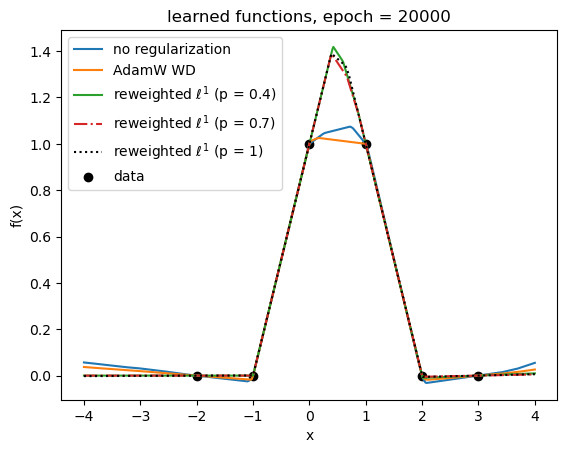

Epoch 25000:  no regularization (MSE=8.55e-08,spars=63,act=63) | WD (MSE=1.27e-08,spars=62,act=62) | p=0.4 (MSE=5.11e-09,spars=5,act=5) | p=0.7 (MSE=1.09e-08,spars=6,act=6) | p=1 (MSE=1.09e-08,spars=6,act=6) | 
Epoch 30000:  no regularization (MSE=1.17e-06,spars=63,act=63) | WD (MSE=5.58e-06,spars=61,act=61) | p=0.4 (MSE=2.28e-08,spars=5,act=5) | p=0.7 (MSE=6.02e-07,spars=5,act=5) | p=1 (MSE=6.02e-07,spars=5,act=5) | 
Epoch 35000:  no regularization (MSE=3.60e-05,spars=63,act=63) | WD (MSE=1.82e-05,spars=60,act=60) | p=0.4 (MSE=2.66e-09,spars=5,act=5) | p=0.7 (MSE=1.08e-08,spars=5,act=5) | p=1 (MSE=1.08e-08,spars=5,act=5) | 
Epoch 40000:  no regularization (MSE=1.17e-08,spars=61,act=61) | WD (MSE=6.63e-09,spars=59,act=59) | p=0.4 (MSE=2.23e-09,spars=5,act=5) | p=0.7 (MSE=3.85e-09,spars=5,act=5) | p=1 (MSE=3.85e-09,spars=5,act=5) | 


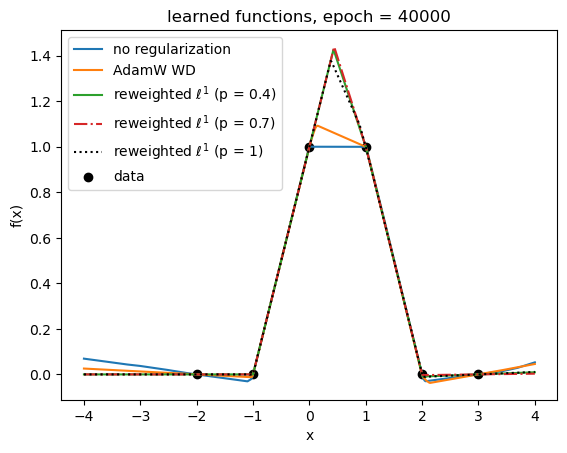

Epoch 45000:  no regularization (MSE=3.45e-07,spars=60,act=60) | WD (MSE=9.80e-08,spars=58,act=58) | p=0.4 (MSE=5.97e-08,spars=5,act=5) | p=0.7 (MSE=5.04e-09,spars=5,act=5) | p=1 (MSE=5.04e-09,spars=5,act=5) | 
Epoch 50000:  no regularization (MSE=5.17e-08,spars=59,act=59) | WD (MSE=8.45e-04,spars=58,act=58) | p=0.4 (MSE=2.36e-08,spars=4,act=4) | p=0.7 (MSE=2.52e-09,spars=4,act=4) | p=1 (MSE=2.52e-09,spars=4,act=4) | 
Epoch 55000:  no regularization (MSE=9.91e-09,spars=59,act=59) | WD (MSE=4.16e-07,spars=58,act=58) | p=0.4 (MSE=1.79e-06,spars=4,act=4) | p=0.7 (MSE=1.52e-07,spars=4,act=4) | p=1 (MSE=1.52e-07,spars=4,act=4) | 
Epoch 60000:  no regularization (MSE=5.94e-11,spars=59,act=59) | WD (MSE=6.56e-06,spars=57,act=57) | p=0.4 (MSE=8.08e-10,spars=3,act=3) | p=0.7 (MSE=2.44e-09,spars=4,act=4) | p=1 (MSE=2.44e-09,spars=4,act=4) | 


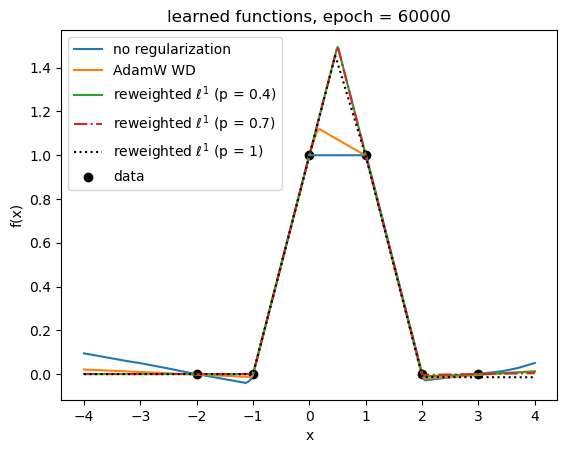

Epoch 65000:  no regularization (MSE=3.29e-07,spars=58,act=58) | WD (MSE=6.16e-09,spars=56,act=56) | p=0.4 (MSE=2.59e-10,spars=3,act=3) | p=0.7 (MSE=3.51e-09,spars=4,act=4) | p=1 (MSE=3.51e-09,spars=4,act=4) | 
Epoch 70000:  no regularization (MSE=7.25e-09,spars=58,act=58) | WD (MSE=1.28e-06,spars=53,act=53) | p=0.4 (MSE=5.25e-09,spars=3,act=3) | p=0.7 (MSE=5.09e-07,spars=4,act=4) | p=1 (MSE=5.09e-07,spars=4,act=4) | 
Epoch 75000:  no regularization (MSE=3.05e-09,spars=57,act=57) | WD (MSE=1.96e-04,spars=53,act=53) | p=0.4 (MSE=6.20e-07,spars=3,act=3) | p=0.7 (MSE=2.54e-09,spars=4,act=4) | p=1 (MSE=2.54e-09,spars=4,act=4) | 
Epoch 80000:  no regularization (MSE=1.00e-07,spars=57,act=57) | WD (MSE=8.28e-07,spars=52,act=52) | p=0.4 (MSE=1.88e-07,spars=3,act=3) | p=0.7 (MSE=1.20e-05,spars=4,act=4) | p=1 (MSE=1.20e-05,spars=4,act=4) | 


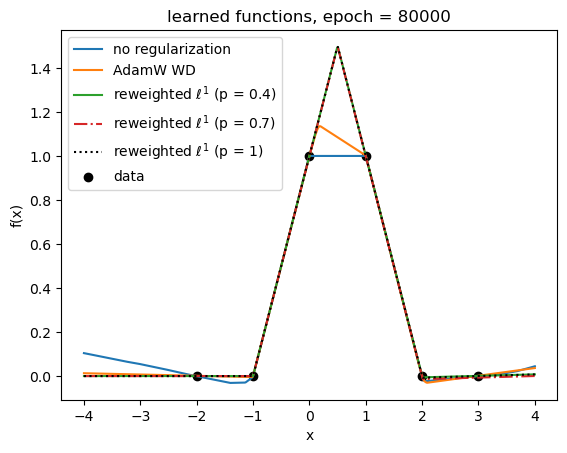

Epoch 85000:  no regularization (MSE=3.92e-07,spars=57,act=57) | WD (MSE=5.66e-07,spars=50,act=50) | p=0.4 (MSE=8.19e-10,spars=3,act=3) | p=0.7 (MSE=2.73e-09,spars=4,act=4) | p=1 (MSE=2.73e-09,spars=4,act=4) | 
Epoch 90000:  no regularization (MSE=2.01e-06,spars=57,act=57) | WD (MSE=8.60e-06,spars=50,act=50) | p=0.4 (MSE=1.93e-08,spars=3,act=3) | p=0.7 (MSE=2.92e-09,spars=4,act=4) | p=1 (MSE=2.92e-09,spars=4,act=4) | 
Epoch 95000:  no regularization (MSE=5.91e-06,spars=57,act=57) | WD (MSE=6.34e-06,spars=47,act=47) | p=0.4 (MSE=7.75e-10,spars=3,act=3) | p=0.7 (MSE=1.65e-08,spars=4,act=4) | p=1 (MSE=1.65e-08,spars=4,act=4) | 
Epoch 100000:  no regularization (MSE=9.27e-05,spars=57,act=57) | WD (MSE=1.09e-05,spars=46,act=46) | p=0.4 (MSE=5.53e-10,spars=3,act=3) | p=0.7 (MSE=6.27e-09,spars=4,act=4) | p=1 (MSE=6.27e-09,spars=4,act=4) | 


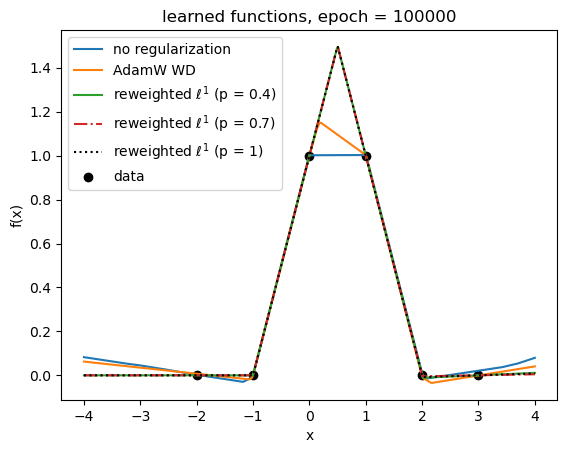

In [4]:
# Training loop
for epoch in range(1, num_epochs+1):
    # no regularizationularization
    opt_none.zero_grad()
    y_none, _ = model_none(x_train)
    loss_none = criterion(y_none, y_train)
    loss_none.backward(); opt_none.step()

    # AdamW
    opt_wd.zero_grad()
    y_wd, _ = model_wd(x_train)
    loss_wd = criterion(y_wd, y_train)
    loss_wd.backward(); opt_wd.step()
    
    p_models_opts = [(p1, model_p1, opt_p1), (p2, model_p2, opt_p2), (p3, model_p3, opt_p3)]
    
    for p, model, opt in p_models_opts:
        prev_V = model.output.weight.data.clone().view(-1,1)
        prev_W = model.hidden.weight.data.clone()
        opt.zero_grad()
        y_pred, _ = model(x_train)
        loss = criterion(y_pred, y_train)
        loss.backward(); opt.step()
    
        if epoch > 5:  # reweighted l1 update
            prev_prod = (prev_V * prev_W)
            C = lambda_reg * gamma * p * prev_prod.abs().pow(p-1)
            new_V = model.output.weight.view(-1,1)
            if incl_bias_sparsity:
                new_W = torch.cat((model.hidden.weight, model.hidden.bias[:, None].data.clone()), dim=1)
            else:
                new_W = model.hidden.weight
            new_prod = new_V * new_W
            sign = new_prod.sign()
            mag = new_prod.abs()
            u = torch.where(mag <= C, torch.zeros_like(new_prod), new_prod - C*sign)
            u_norms = torch.linalg.vector_norm(u, dim=1, ord=2)
            mask = (u_norms >= eps) 
            den = torch.sqrt(u_norms).masked_fill(~mask, 1.0)
            u_div = (torch.abs(u) / den[:, None]).masked_fill(~mask[:, None], 0.0)

            model.output.weight.data = torch.sqrt(u_norms).reshape(model.output.weight.data.shape) * torch.sign(model.output.weight.data)
            if incl_bias_sparsity:
                model.hidden.weight.data = u_div[:, :-1].reshape(model.hidden.weight.data.shape) * torch.sign(model.hidden.weight.data)
                model.hidden.bias.data = u_div[:, -1].reshape(model.hidden.bias.data.shape) * torch.sign(model.hidden.bias.data)
            else:
                model.hidden.weight.data = u_div.reshape(model.hidden.weight.data.shape) * torch.sign(model.hidden.weight.data)
        
    # Record and print
    if epoch % 5000 == 0 or epoch == 1 or epoch == num_epochs:
        # print(loss.item())
        # print(err_thresh.item())
        epochs.append(epoch)
        for name, model in [('none', model_none), ('wd', model_wd), ('p1', model_p1), ('p2', model_p2), ('p3', model_p2)]:
            y_pred, _ = model(x_train)
            metrics[name]['mse'].append(criterion(y_pred, y_train).item())
            # metrics[name]['mse'].append(err_thresh.item())
            metrics[name]['spars'].append(count_nonzero(model))
            metrics[name]['act'].append(count_active_neurons(model))
            if name == 'p1':
                metrics[name]['lp'].append(lp_path_norm(model, p1))
            elif name == 'p2':
                metrics[name]['lp'].append(lp_path_norm(model, p2))
            elif name == 'p3':
                metrics[name]['lp'].append(lp_path_norm(model, p3))

        print(f"Epoch {epoch}:  "
              f"no regularization (MSE={metrics['none']['mse'][-1]:.2e},spars={metrics['none']['spars'][-1]},act={metrics['none']['act'][-1]}) | "
              f"WD (MSE={metrics['wd']['mse'][-1]:.2e},spars={metrics['wd']['spars'][-1]},act={metrics['wd']['act'][-1]}) | "
              f"p={p1} (MSE={metrics['p1']['mse'][-1]:.2e},spars={metrics['p1']['spars'][-1]},act={metrics['p1']['act'][-1]}) | "
              f"p={p2} (MSE={metrics['p2']['mse'][-1]:.2e},spars={metrics['p2']['spars'][-1]},act={metrics['p2']['act'][-1]}) | "
              f"p={p3} (MSE={metrics['p2']['mse'][-1]:.2e},spars={metrics['p3']['spars'][-1]},act={metrics['p3']['act'][-1]}) | ")
        
    if epoch % 20000 == 0 or epoch == 1:
        # Plot learned functions
        eval_x = torch.linspace(-4.0, 4.0, 500).unsqueeze(1)
        with torch.no_grad():
            y_none_eval, _ = model_none(eval_x)
            y_wd_eval, _ = model_wd(eval_x)
            y_p1_eval, _ = model_p1(eval_x)
            y_p2_eval, _ = model_p2(eval_x)
            y_p3_eval, _ = model_p3(eval_x)
        
        plt.figure()
        plt.plot(eval_x, y_none_eval, '-', label='no regularization')
        plt.plot(eval_x, y_wd_eval, '-', label='AdamW WD')
        plt.plot(eval_x, y_p1_eval, '-', label='reweighted $\ell^1$ (p = {})'.format(p1))
        plt.plot(eval_x, y_p2_eval, '-.', label='reweighted $\ell^1$ (p = {})'.format(p2))
        plt.plot(eval_x, y_p3_eval, ':', color='black', label='reweighted $\ell^1$ (p = {})'.format(p3))
        plt.scatter(x_train, y_train, color='black', label='data')
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.title('learned functions, epoch = {}'.format(epoch))
        fig_path = fig_dir + 'learned_functions_epoch_{}.png'.format(epoch)
        if save_figs:
            plt.savefig(fig_path, dpi=300)
        plt.show()


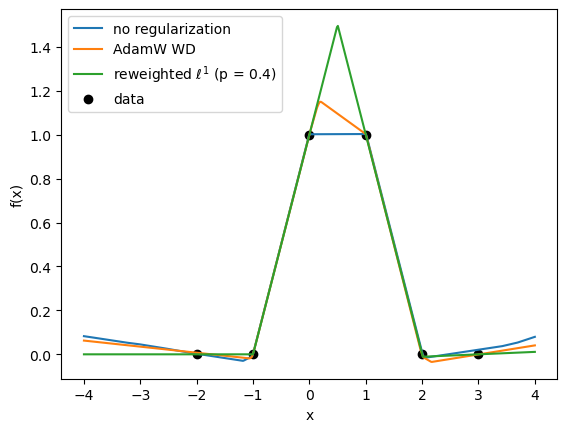

In [5]:
# Plot learned functions for only no regularization, WD, p1
eval_x = torch.linspace(-4.0, 4.0, 500).unsqueeze(1)
with torch.no_grad():
    y_none_eval, _ = model_none(eval_x)
    y_wd_eval, _ = model_wd(eval_x)
    y_p1_eval, _ = model_p1(eval_x)

plt.figure()
plt.plot(eval_x, y_none_eval, '-', label='no regularization')
plt.plot(eval_x, y_wd_eval, '-', label='AdamW WD')
plt.plot(eval_x, y_p1_eval, '-', label='reweighted $\ell^1$ (p = {})'.format(p1))
plt.scatter(x_train, y_train, color='black', label='data')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
fig_path = fig_dir + 'learned_functions_final_p1_noreg_WD.png'
if save_figs:
    plt.savefig(fig_path, dpi=300)
plt.show()

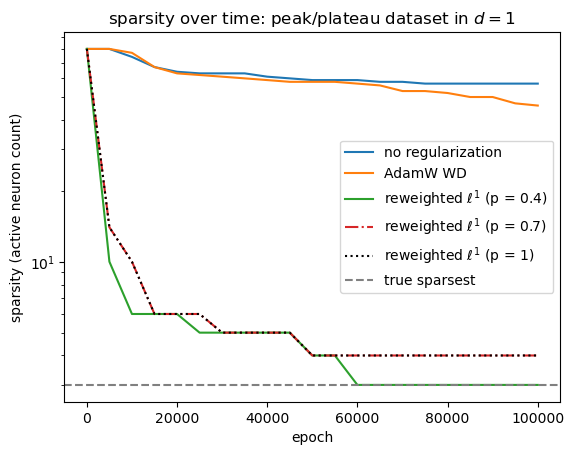

In [8]:
# Plot sparsity over time
plt.figure()
plt.plot(epochs, metrics['none']['spars'], '-', label='no regularization')
plt.plot(epochs, metrics['wd']['spars'], '-', label='AdamW WD')
plt.plot(epochs, metrics['p1']['spars'], '-', label='reweighted $\ell^1$ (p = {})'.format(p1))
plt.plot(epochs, metrics['p2']['spars'], '-.', label='reweighted $\ell^1$ (p = {})'.format(p2))
plt.plot(epochs, metrics['p3']['spars'], ':', color='black', label='reweighted $\ell^1$ (p = {})'.format(p3))

plt.yscale('log')
plt.xlabel('epoch'); plt.ylabel('sparsity (active neuron count)')
plt.axhline(y=3, color='gray', linestyle='--', label='true sparsest')
plt.title('sparsity over time: peak/plateau dataset in $d = 1$')
plt.legend()
fig_path = fig_dir + 'sparsity_over_time_univariate.png'
if save_figs:
    plt.savefig(fig_path, dpi=300)
plt.show()

